# Implementação DQN com prioritized replay no ambiente Swift com manipulador panda.

Replay buffer <br>
DNN para representar o agente atual e uma DNN alvo com uma taxa de atualização menor.

In [1]:
import torch
import json
import pickle
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output
from scipy.signal import convolve, gaussian
import os
import io
import base64
import time
import glob
from IPython.display import HTML

import data_panda as rbt
device = 'cpu'
%matplotlib inline


#j3 range -0.08 a 3.75  #j2 range -0.07 a -3. #j1 range -1.8 a 1.76

### Sistema observável e com medidas dos ângulos disponíveis


    Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Joint1                   -4.8                    4.8
        1       Joint2                    -Inf                    Inf
        2       Joint3                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        
    Actions:
        Type: Discrete(9)
        Num   Three actions for each joint
        0     decrement joint j
        1     increment joint j
        2     decrement join  j

        #j3 range 0.0 a 3.7
        #j2 range 0.0 a -3.
        #j1 range -1.7 a 1.7


        



In [2]:
state_shape = 3
env=rbt.Panda_RL()
agent=rbt.DQNAgent(state_shape, device, epsilon=0)
env.renderize=True #stop robot viewing

In [3]:
env.panda

ERobot: panda (by Franka Emika), 7 joints (RRRRRRR), 1 gripper, geometry, collision
┌─────┬──────────────┬───────┬─────────────┬────────────────────────────────────────────────┐
│link │     link     │ joint │   parent    │              ETS: parent to link               │
├─────┼──────────────┼───────┼─────────────┼────────────────────────────────────────────────┤
│   0 │ panda_link0  │       │ BASE        │                                                │
│   1 │ panda_link1  │     0 │ panda_link0 │ SE3(0, 0, 0.333) ⊕ Rz(q0)                      │
│   2 │ panda_link2  │     1 │ panda_link1 │ SE3(-90°, -0°, 0°) ⊕ Rz(q1)                    │
│   3 │ panda_link3  │     2 │ panda_link2 │ SE3(0, -0.316, 0; 90°, -0°, 0°) ⊕ Rz(q2)       │
│   4 │ panda_link4  │     3 │ panda_link3 │ SE3(0.0825, 0, 0; 90°, -0°, 0°) ⊕ Rz(q3)       │
│   5 │ panda_link5  │     4 │ panda_link4 │ SE3(-0.0825, 0.384, 0; -90°, -0°, 0°) ⊕ Rz(q4) │
│   6 │ panda_link6  │     5 │ panda_link5 │ SE3(90°, -0°, 0°) ⊕ Rz(q5

### Main loop



Intializing with a given state

In [4]:
env.start_scene()

In [5]:
q_far=np.array([ 0., -0.8 ,  0. , -0.0698,  0.,  3.3825,  0.    ])
print(env.reach_joint_limit())

[False, True, False]


In [6]:
rbt.evaluate(env, agent, n_games=1, greedy=False, t_max=100)

/home/taniel/anaconda3/envs/RTB/lib/python3.10/site-packages/roboticstoolbox/robot/Link.py:1041: FutureWarning: base kwarg is deprecated, use pose instead
  warn("base kwarg is deprecated, use pose instead", FutureWarning)
pybullet build time: Jul 21 2022 19:48:53


(-911.0005006822514,
 46.0,
 1.0,
 0.0,
 4.6761342528823135,
 [['Termination', 'Collided']])

In [7]:
env.reset_j1=[-1.7,-1.]
env.reset()

array([-1.17, -1.45,  0.26])

In [8]:
a=np.array([-1,0,1])

env.step(a)

(array([-1.18, -1.45,  0.27]), -20.702413599427302, False, ['Running', ''])

In [9]:
a=np.array([-1,0,0])
for i in range(100):
    env.step(a)
# if info[1]=="Collided":
#     env.step(-a)
print(env.step(a))

(array([-1.73, -1.45,  0.27]), -10, False, ['Termination', 'Collided'])


In [10]:
env.panda.q=env.q_goal
env.sig_R=1
print(env.step([1,1,-1]))
print(env.fitness())
# print(env.step([0,0,1]))
# print(env.fitness())

(array([ 0.36, -0.83,  3.68]), 10.706097320793331, False, ['Running', ''])
(3.2599151422785155, 0.010000000000023646)


In [438]:
print(env.step([0,0,-1]))

(array([ 0.09, -1.08,  3.3 ]), -19.691713246230844, False, ['Running', ''])


In [439]:
print(env.step([1,0,0]))
print(env.fitness())

(array([ 0.1 , -1.08,  3.3 ]), 9.67427263231431, False, ['Running', ''])
(3.280883383345418, 0.38000000000003054)


In [408]:

print(env.step([0,1,-1]))

#print(env.fitness())
#j=[(-1.8,1.76), (-3,0),(0,3.75)]




(array([ 0.09, -1.08,  3.58]), -10, False, ['Termination', 'Collided'])


Final score:-2676.506951133678 in 600 steps, minimum distance 3.6606851047299944
Status: Running 


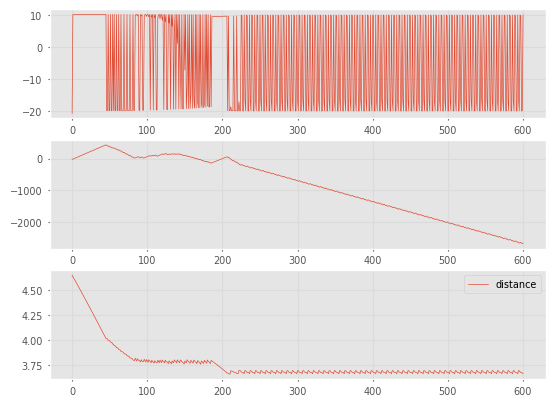

In [440]:
folder="new_step_26"
env.reset_j1=[-1.7,-1.]
agent.play(env,folder,tmax=600,plot=True)

In [444]:
agent.play(env,folder,tmax=500,model="other")


Final score:-1074.4381336820925 in 500 steps, minimum distance 3.6673888684129725
Status: Running 


In [442]:
agent.play(env,folder,tmax=700,model="last")

Final score:-2388.471146804559 in 700 steps, minimum distance 3.60150610598612
Status: Running 


In [21]:
env.Rg

array([[-5.66494083e-01, -5.66494083e-01,  5.98472144e-01],
       [ 7.07106781e-01, -7.07106781e-01,  7.00686929e-18],
       [ 4.23183711e-01,  4.23183711e-01,  8.01143616e-01]])

In [22]:
R

array([[-5.62233992e-01, -5.62233992e-01,  6.06453523e-01],
       [ 7.07106781e-01, -7.07106781e-01,  7.37577446e-18],
       [ 4.28827399e-01,  4.28827399e-01,  7.95118937e-01]])

In [152]:
DIR='runs/results_25/'
print(glob.glob(DIR+'/*.pt'))

['runs/results_25/best-model-loss.pt', 'runs/results_25/best-model-rw.pt']


**Let us record a video of trained agent**

In [72]:
# # Animate learned policy
# save_dir='./videos/'
# #env = make_env(env_name)
# generate_animation(env, agent, save_dir=save_dir)
# [filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))

# display_animation(filepath)

In [73]:
#TODO

# Run this on another environment in OpenAI Gym
# Create a robotic environment with more actions
#